# Anomaly Detection on Images Using PCA with Google Vertex AI

This notebook demonstrates how to perform anomaly detection on images using Principal Component Analysis (PCA). We'll use Google Vertex AI embeddings through LangChain to extract features from images, and then apply PCA to identify anomalous patterns.

**Date:** April 25, 2025

## Overview

1. Set up the environment
2. Load and preprocess images
3. Generate embeddings using Vertex AI via LangChain
4. Apply PCA for dimensionality reduction
5. Detect anomalies using reconstruction error
6. Visualize and evaluate results

## 1. Environment Setup

First, let's install any additional packages we might need and set up our authentication for Google Vertex AI.

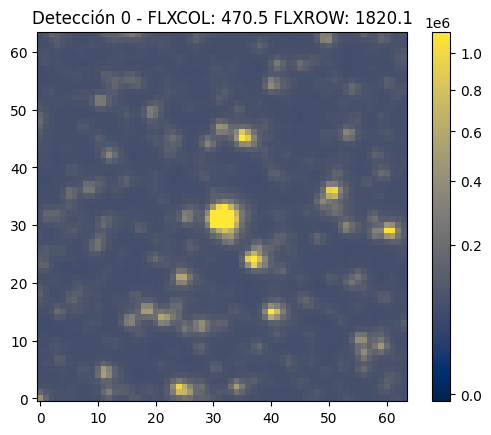

In [1]:
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import numpy as np

# Cargar imagen
hdul = fits.open(
    "/home/atelo/projects/anomaly_reaper/data/s0027/cam1-ccd1/hlsp_tica_tess_ffi_s0027-o1-00116491-cam1-ccd1_tess_v01_img.fits"
)
image_data = hdul[0].data
catalog = hdul[1].data

# Normalización inteligente
norm = simple_norm(image_data, stretch="sqrt", percent=99)  # Stretch raíz segura

# Primera detección
x = catalog["FLXCOL"][0]
y = catalog["FLXROW"][0]

# Cortar parche 64x64
half_size = 32
x_min = int(x) - half_size
x_max = int(x) + half_size
y_min = int(y) - half_size
y_max = int(y) + half_size
cutout = image_data[y_min:y_max, x_min:x_max]

# Mostrar con normalización bien hecha
plt.imshow(cutout, norm=norm, cmap="cividis", origin="lower")
plt.colorbar()
plt.title(f"Detección 0 - FLXCOL: {x:.1f} FLXROW: {y:.1f}")
plt.show()

/home/atelo/projects/anomaly_reaper/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


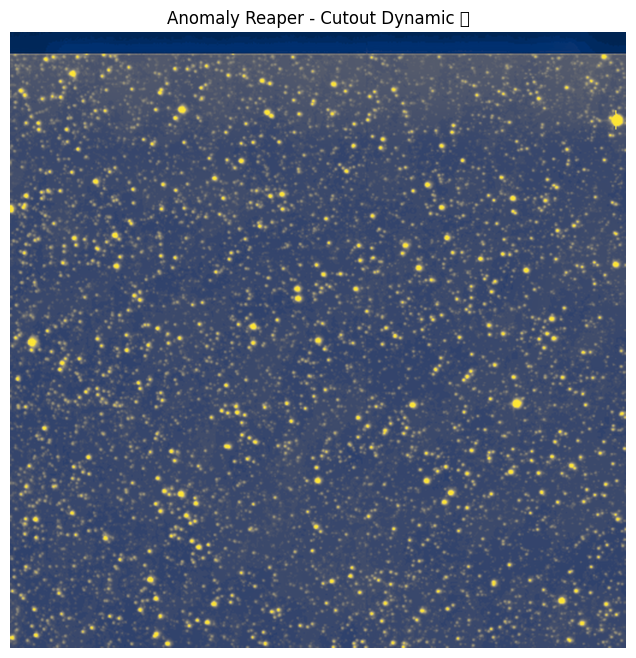

((1024, 1024), {'x_min': 493, 'x_max': 533, 'y_min': 492, 'y_max': 532})

In [2]:
from astropy.io import fits
from astropy.visualization import simple_norm
from skimage import exposure, restoration
from skimage.transform import resize
import matplotlib.pyplot as plt


def preprocess_cutout_dynamic(
    image_data, x, y, min_cutout_size=512, final_size=(1024, 1024)
):
    """
    Preprocesa un recorte alrededor de (x, y) garantizando tamaño mínimo y devuelve:
    - Imagen procesada.
    - Bounding box del objeto en la imagen upscalada.
    """
    # Calcular tamaño de recorte
    half_size = max(min_cutout_size // 2, 32)
    x_min = max(int(x) - half_size, 0)
    x_max = min(int(x) + half_size, image_data.shape[1])
    y_min = max(int(y) - half_size, 0)
    y_max = min(int(y) + half_size, image_data.shape[0])

    # Recortar
    cutout = image_data[y_min:y_max, x_min:x_max]

    # Stretch seguro
    norm = simple_norm(cutout, stretch="sqrt", percent=99)
    cutout_norm = norm(cutout)
    cutout_norm = np.clip(cutout_norm, 0, 1)

    # Denoising
    cutout_denoised = restoration.denoise_bilateral(
        cutout_norm, sigma_color=0.05, sigma_spatial=15, channel_axis=None
    )

    # Enhance contraste
    cutout_contrast = exposure.equalize_adapthist(cutout_denoised, clip_limit=0.03)

    # Upscale final
    cutout_upscaled = resize(
        cutout_contrast, final_size, order=3, mode="reflect", anti_aliasing=True
    )

    # Calcular bounding box relativo al cutout upscalado
    scale_x = final_size[0] / cutout.shape[1]
    scale_y = final_size[1] / cutout.shape[0]

    x_center = (x - x_min) * scale_x
    y_center = (y - y_min) * scale_y

    bbox_size = 20  # tamaño fijo para debug/visual

    bbox = {
        "x_min": int(x_center - bbox_size),
        "x_max": int(x_center + bbox_size),
        "y_min": int(y_center - bbox_size),
        "y_max": int(y_center + bbox_size),
    }

    return cutout_upscaled, bbox


# --- Ejemplo de uso ---

# Cargar FITS
hdul = fits.open(
    "/home/atelo/projects/anomaly_reaper/data/s0027/cam1-ccd1/hlsp_tica_tess_ffi_s0027-o1-00116482-cam1-ccd1_tess_v01_img.fits"
)
image_data = hdul[0].data
catalog = hdul[1].data

# Coordenadas de un objeto
x = catalog["FLXCOL"][0]
y = catalog["FLXROW"][0]

# Procesar corte dinámico
processed_cutout, bbox = preprocess_cutout_dynamic(
    image_data, x, y, min_cutout_size=512, final_size=(1024, 1024)
)

# Mostrar
plt.figure(figsize=(8, 8))
plt.imshow(processed_cutout, cmap="cividis", origin="lower")
plt.axis("off")
plt.title("Anomaly Reaper - Cutout Dynamic 🚀")
plt.show()

processed_cutout.shape, bbox

In [3]:
def debug_show_cutout_and_bbox(
    image_upscaled, bbox, title="Debug View - Bounding Box 🧠"
):
    """
    Visualiza la imagen upscalada completa con su bounding box correctamente dibujado.
    Args:
        image_upscaled (numpy.ndarray): Imagen ya upscalada (ej: 1024x1024).
        bbox (dict): Diccionario con las coordenadas del bounding box (x_min, x_max, y_min, y_max).
        title (str): Título opcional para el plot.
    """
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 8))

    # Mostrar la imagen upscalada
    ax.imshow(image_upscaled, cmap="plasma", origin="lower")

    # Dibujar el bounding box real basado en el tamaño de la imagen
    rect = plt.Rectangle(
        (bbox["x_min"], bbox["y_min"]),  # origen (x_min, y_min)
        bbox["x_max"] - bbox["x_min"],  # ancho
        bbox["y_max"] - bbox["y_min"],  # alto
        edgecolor="red",
        facecolor="none",
        linewidth=2,
    )
    ax.add_patch(rect)

    ax.set_title(title)
    ax.axis("off")
    plt.show()

/home/atelo/projects/anomaly_reaper/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


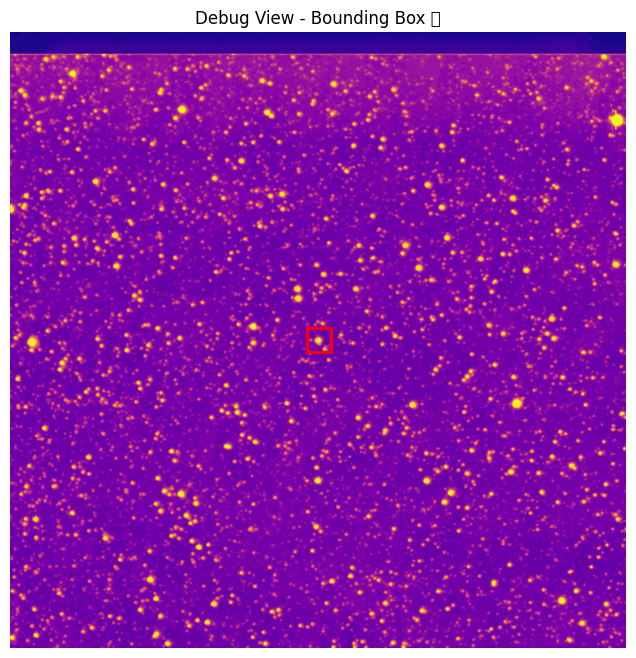

In [4]:
debug_show_cutout_and_bbox(processed_cutout, bbox)

In [6]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

## 2. Google Vertex AI Authentication

To use Google Vertex AI services, we need to set up our authentication. If running locally, make sure you have the Google Cloud SDK installed and configured. If running in a Google Colab, you might need to authenticate interactively.

In [ ]:
import vertexai

# Set up Google Cloud authentication
# Uncomment and run the following if using in Colab:
# from google.colab import auth
# auth.authenticate_user()

# Get project ID from environment variables
PROJECT_ID = os.getenv("ANOMALY_REAPER_PROJECT_ID")
LOCATION = os.getenv(
    "ANOMALY_REAPER_LOCATION", "us-central1"
)  # Default to us-central1 if not specified

# Print the project ID (not the actual value) for debugging
print(
    f"Using Google Cloud Project ID: {PROJECT_ID[:3]}...{PROJECT_ID[-3:] if PROJECT_ID else None}"
)
print(f"Location: {LOCATION}")


vertexai.init(project=PROJECT_ID, location=LOCATION)

Using Google Cloud Project ID: lan...ust
Location: us-central1


## 3. Load and Preprocess Images

Let's define a function to load images from a directory and preprocess them for embedding generation.

In [8]:
from pathlib import Path
from json import dumps, loads
from typing import Generator


def load_images(
    image_dir, limit=None, bypass=False
) -> Generator[None, tuple[str, np.ndarray], None]:
    """Load images from a directory.

    Args:
        image_dir (str): Directory containing images
        limit (int, optional): Maximum number of images to load. Defaults to None.

    Returns:
        list: List of image paths
        list: List of PIL Image objects
    """
    seen = set()
    cache_file_json = Path(image_dir) / "image_cache.json"
    if not cache_file_json.exists():
        cache_file_json.write_text(dumps(list(seen)))
    else:
        seen = set(loads(cache_file_json.read_text()))

    images_target_path = Path(image_dir) / "images"
    images_target_path.mkdir(exist_ok=True)

    image_paths = Path(image_dir).glob("*.fits")

    target_images_paths = set(images_target_path.glob("*.png"))

    images_count = len(list(target_images_paths))

    if not bypass:
        for image_path in image_paths:
            if image_path.stem in seen:
                continue
            hdul = fits.open(image_path)
            image_data = hdul[0].data
            catalog = hdul[1].data

            for anomaly in catalog:
                # Coordenadas de un objeto
                x = anomaly["FLXCOL"]
                y = anomaly["FLXROW"]

                proposed_image = images_target_path / f"{image_path.stem}_{x}_{y}.png"

                if proposed_image.exists():
                    print(f"Image {proposed_image} already exists, skipping...")
                    continue

                # Procesar corte dinámico
                processed_cutout, bbox = preprocess_cutout_dynamic(
                    image_data, x, y, min_cutout_size=512, final_size=(1024, 1024)
                )

                # Guardar imagen procesada
                cutout_image = Image.fromarray(
                    (processed_cutout * 255).astype(np.uint8)
                )
                cutout_image.save(proposed_image)
                images_count += 1

                if limit and images_count >= limit:
                    break

            seen.add(image_path.stem)

    # Save the updated seen set to the cache file
    cache_file_json.write_text(dumps(list(seen)))
    # Return the list of image paths and loaded images

    image_paths = list(images_target_path.glob("*.png"))
    for image_index, image_path in enumerate(image_paths):
        if limit and image_index + 1 >= limit:
            break
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = np.array(image)

        yield image_path, image

In [9]:
# Set your image directory path
IMAGE_DIR = "./data/s0027/cam1-ccd1"

# Load images (limit to a smaller number for testing)
image_generator = load_images(IMAGE_DIR, limit=35, bypass=True)

## 4. Generate Embeddings with Vertex AI using LangChain

Now, let's use Vertex AI through LangChain to generate embeddings for our images. We'll use the multimodal embedding model from Vertex AI which can process both images and text.

In [10]:
def encode_image_base64(image):
    """Convert a PIL Image to base64 encoding, which is required by some Vertex AI models.

    Args:
        image (PIL.Image): The image to encode

    Returns:
        str: Base64 encoded image
    """
    import base64
    import io

    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    elif not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image or a NumPy array.")

    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str

In [11]:
from vertexai.vision_models import MultiModalEmbeddingModel
from vertexai.vision_models import Image as VertexImage

embeddings_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

In [14]:
import base64


def get_image_embeddings(images, dimension=1408):
    """Generate embeddings for a list of images using Vertex AI.

    Args:
        images (list): List of PIL Image objects

    Returns:
        np.ndarray: Matrix of embeddings (num_images × embedding_dimension)
    """

    print("Preparing images for embedding...")

    for image_idx, image in enumerate(images):
        image = VertexImage(
            image_bytes=base64.decodebytes(encode_image_base64(image)),
        )

        print(f"Processing image {image_idx + 1}/{len(images)}...")

        yield embeddings_model.get_embeddings(
            image=image,
            dimension=dimension,
            contextual_text="deep space image with and anomaly detected by an automated system",
        ).image_embedding

        print(f"Image {image_idx + 1}/{len(images)} processed.")

In [15]:
image_generator = load_images(IMAGE_DIR, limit=None, bypass=True)

# Load images from the generator
images = []
images_path = []

for image_path, image in image_generator:
    images.append(image)
    images_path.append(str(image_path))
    print(f"Loaded image: {image_path}")
# Convert to numpy array for processing
images = np.array(images)
print(f"Loaded {len(images)} images.")
# Check the shape of the images
print(f"Shape of first image: {images[0].shape}")

# Generate embeddings for our images
image_embeddings = list(get_image_embeddings(images))

Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00117223-cam1-ccd1_tess_v01_img_998.1143188476562_391.3247985839844.png
Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00117300-cam1-ccd1_tess_v01_img_470.46624755859375_1820.0968017578125.png
Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00116516-cam1-ccd1_tess_v01_img_257.4248046875_398.4631042480469.png
Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00117414-cam1-ccd1_tess_v01_img_978.938232421875_1122.3870849609375.png
Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00117223-cam1-ccd1_tess_v01_img_1712.3963623046875_409.9850158691406.png
Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00118109-cam1-ccd1_tess_v01_img_470.50933837890625_1820.09912109375.png
Loaded image: data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi_s0027-o1-00117130-cam1-ccd1_tess_v01_img_978.9425048828125_1122.381103515625.png
Loaded

In [16]:
print(f"Generated embeddings with shape: {np.array(image_embeddings).shape}")

Generated embeddings with shape: (307, 1408)


## 5. Apply PCA for Dimensionality Reduction

Now that we have our embeddings, we'll apply PCA to reduce dimensionality and prepare for anomaly detection.

# PCA-Based Anomaly Detection for Image Clustering

This notebook demonstrates how to perform anomaly detection on images using Principal Component Analysis (PCA) with embeddings generated from VertexAI through LangChain. The process involves:

1. Generating embeddings for images using VertexAI
2. Reducing dimensionality with PCA
3. Detecting anomalies based on reconstruction error
4. Visualizing the results

## Install and Import Required Libraries

First, let's install the necessary libraries for this project.

## Apply PCA for Dimensionality Reduction

Now that we have our image embeddings, let's apply PCA to reduce their dimensionality while retaining most of the variance.

In [5]:
import numpy as np

DATA_PATH = Path("data")

# Convert embeddings to a numpy array for PCA

try:
    image_embeddings_csv = Path(DATA_PATH) / "image_embeddings.csv"
    image_paths_csv = Path(DATA_PATH) / "image_paths.csv"
except Exception as e:
    if Path(DATA_PATH).exists():
        image_embeddings_csv = Path(DATA_PATH) / "image_embeddings.csv"
        image_paths_csv = Path(DATA_PATH) / "image_paths.csv"
    else:
        raise e


try:
    X = np.array(image_embeddings)
except Exception as e:
    if image_embeddings_csv.exists() and image_paths_csv.exists():
        print("Loading embeddings from CSV...")
        X = pd.read_csv(image_embeddings_csv).values
        images_path = pd.read_csv(image_paths_csv).values.flatten()
    else:
        raise e

with image_embeddings_csv.open("w") as f:
    pd.DataFrame(X).to_csv(f, index=False)


with image_paths_csv.open("w") as f:
    pd.DataFrame(images_path).to_csv(f, index=False)

Loading embeddings from CSV...


Principal components shape: (307, 2)
Explained variance ratio: [0.48160587 0.10691347]
Cumulative explained variance: 0.5885


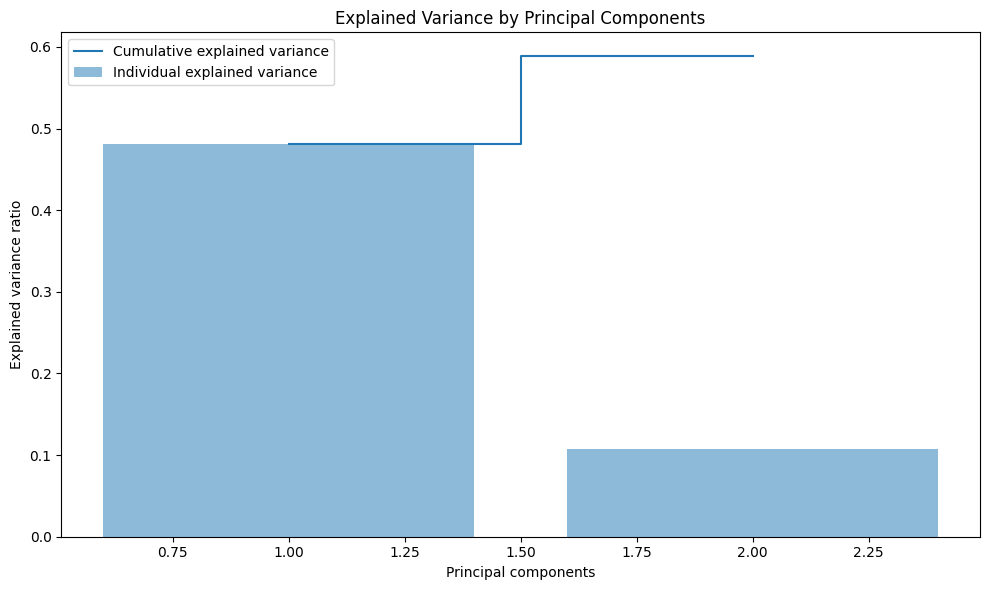

In [7]:
import pickle
import matplotlib.pyplot as plt


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = 2  # Start with 2 for visualization purposes
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
print(f"Principal components shape: {principal_components.shape}")

pickle.dump(
    pca,
    (Path(DATA_PATH) / "pca_model.pkl").open("wb"),
)


# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Explained variance ratio: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_variance[-1]:.4f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, n_components + 1),
    explained_variance,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, n_components + 1),
    cumulative_variance,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.title("Explained Variance by Principal Components")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

embeddings_df = pd.DataFrame(
    principal_components, columns=[f"PC{i + 1}" for i in range(n_components)]
)

embeddings_df["image_path"] = images_path

## Detect Anomalies Using PCA

Now we'll detect anomalies using the reconstruction error from PCA. Anomalies will have higher reconstruction error compared to normal data points.

In [8]:
# Calculate reconstruction error
X_reconstructed = pca.inverse_transform(principal_components)
reconstruction_error = np.linalg.norm(X_scaled - X_reconstructed, axis=1)

# Add reconstruction error to the DataFrame
embeddings_df["reconstruction_error"] = reconstruction_error

# Set a threshold for anomaly detection
# A simple approach is to use the mean + 2*std as the threshold
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
embeddings_df["is_anomaly"] = embeddings_df["reconstruction_error"] > threshold

# Count anomalies
anomaly_count = embeddings_df["is_anomaly"].sum()
print(f"Detected {anomaly_count} anomalies out of {len(embeddings_df)} images")
print(f"Anomaly threshold (reconstruction error): {threshold:.4f}")

# Sort by reconstruction error to see the most anomalous images
anomalies = embeddings_df.sort_values("reconstruction_error", ascending=False)
anomalies.head(10)

Detected 9 anomalies out of 307 images
Anomaly threshold (reconstruction error): 44.4552


,PC1,PC2,image_path,reconstruction_error,is_anomaly
241,-33.604667,-3.789289,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,70.185606,True
95,0.912984,-9.474542,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,63.314078,True
279,-36.227329,12.144300,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,62.832161,True
272,-18.171910,-18.589987,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,50.805306,True
268,-12.618662,-17.692045,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,49.203761,True
150,-43.432372,14.827659,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,48.838496,True
26,4.140867,-6.158512,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,45.874151,True
304,-14.426936,0.941484,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,45.532702,True
22,-9.287781,2.878370,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,45.407397,True
260,-18.320161,4.730783,data/s0027/cam1-ccd1/images/hlsp_tica_tess_ffi...,43.797822,False


In [9]:
embeddings_df["is_anomaly"].value_counts()

is_anomaly
False    298
True       9
Name: count, dtype: int64

## Visualize Clusters and Anomalies

Let's visualize the clusters and highlight the anomalies using scatter plots.

In [10]:
# cache the embeddings_df
from pathlib import Path
import pandas as pd

embeddings_path = Path("data") / "embeddings_df.csv"

if not embeddings_path.exists():
    # Save the DataFrame to a CSV file
    embeddings_df.to_csv(embeddings_path, index=False)
    print(f"Embeddings DataFrame saved to {embeddings_path}")
else:
    # Load the DataFrame from the CSV file
    embeddings_df = pd.read_csv(embeddings_path)
    print(f"Embeddings DataFrame loaded from {embeddings_path}")

Embeddings DataFrame loaded from data/embeddings_df.csv


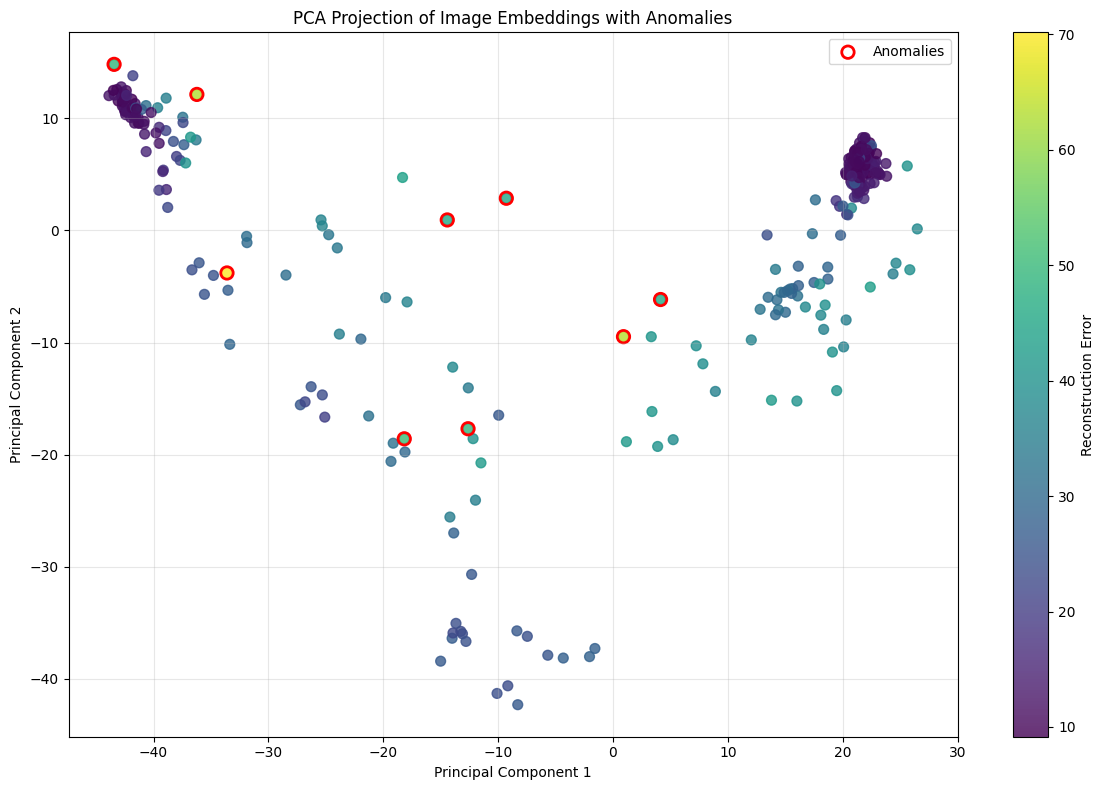

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px


# Create a scatter plot with PCA components
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_df["PC1"],
    embeddings_df["PC2"],
    c=embeddings_df["reconstruction_error"],
    cmap="viridis",
    s=50,
    alpha=0.8,
)

# Highlight anomalies with a red circle
anomalies = embeddings_df[embeddings_df["is_anomaly"]]
plt.scatter(
    anomalies["PC1"],
    anomalies["PC2"],
    color="none",
    edgecolor="red",
    s=80,
    linewidth=2,
    label="Anomalies",
)

plt.colorbar(scatter, label="Reconstruction Error")
plt.title("PCA Projection of Image Embeddings with Anomalies")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create an interactive plot with Plotly
fig = px.scatter(
    embeddings_df,
    x="PC1",
    y="PC2",
    color="reconstruction_error",
    hover_data=["image_path", "reconstruction_error"],
    title="Interactive PCA Projection with Anomalies",
    labels={
        "PC1": "Principal Component 1",
        "PC2": "Principal Component 2",
        "reconstruction_error": "Reconstruction Error",
    },
    color_continuous_scale="viridis",
)

# Add markers for anomalies
fig.add_scatter(
    x=anomalies["PC1"],
    y=anomalies["PC2"],
    mode="markers",
    marker=dict(size=15, color="rgba(255,0,0,0)", line=dict(color="red", width=2)),
    name="Anomalies",
    hoverinfo="skip",
)

fig.update_layout(height=600, width=900)

fig.show()

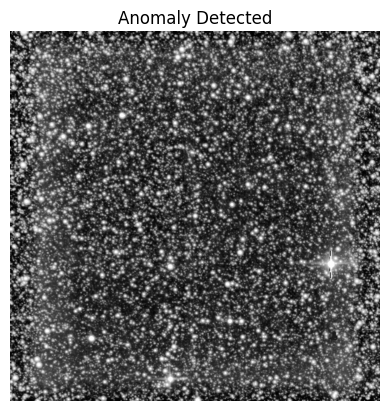

In [ ]:
test_anomaly_path = embeddings_df[embeddings_df["is_anomaly"] == True].iloc[0][  # noqa: E712
    "image_path"
]

test_anomaly = Image.open(test_anomaly_path)
test_anomaly = test_anomaly.convert("RGB")

plt.imshow(test_anomaly)
plt.axis("off")
plt.title("Anomaly Detected")
plt.show()

## Conclusion

In this notebook, we've demonstrated how to:

1. Load and preprocess images
2. Generate embeddings using VertexAI through LangChain
3. Apply PCA for dimensionality reduction
4. Detect anomalies using reconstruction error
5. Visualize clusters and anomalies

This approach can be particularly useful for identifying unusual or outlier images in a dataset, which could represent errors, rare cases, or images that need special attention.

### Next Steps:
- Experiment with different embedding models
- Try other anomaly detection techniques (Isolation Forest, One-Class SVM, etc.)
- Apply this methodology to specific image datasets for practical applications
- Improve visualization by showing actual images alongside the scatter plot